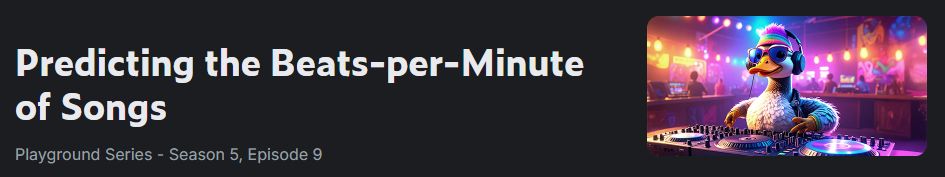
* https://www.kaggle.com/competitions/playground-series-s5e9
* 위 공모전의 목표: 주어진 노래의 여러 특징(feature)들을 기반으로 해당 곡의 BPM(박자 수) 을 예측하는 것

In [24]:
# ================================
# 0) 표준 라이브러리
# ================================
import math
import warnings

# ================================
# 1) 과학계산 & 시각화
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 주피터 노트북 표시용 (넓은 레이아웃)
from IPython.display import display, HTML

# ================================
# 2) 머신러닝 라이브러리 (scikit-learn)
# ----------------
# - 데이터 분할/검증, 전처리, 모델, 평가, 파이프라인 등
# ================================
import sklearn  # 버전 확인/디버깅용 (직접 사용은 안해도 무방)

# (2-1) 데이터 분할 & 검증
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    GridSearchCV,
)

# (2-2) 모델: 선형/트리/앙상블/SVM
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR

# (2-3) 전처리 & 특성공학
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# (2-4) 타깃 변환 회귀 (y 스케일링 등)
from sklearn.compose import TransformedTargetRegressor

# (2-5) 평가 지표
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,  # sklearn >= 1.3
    r2_score,
)

# ================================
# 3) 부가 모델 (부스터 계열)
# ================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ================================
# 4) 환경 설정 (경고, 시각화 폰트/스타일, 판다스 옵션)
# ================================

# 경고 숨김 (필요 시 주석 처리하여 확인 가능)
warnings.filterwarnings(action='ignore')

# 시본 기본 스타일
sns.set()

# 한글 폰트 & 마이너스 기호 깨짐 방지 (Windows: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 주피터 노트북 출력 폭 확장
display(HTML("<style>.container{width:100% !important;}</style>"))

# 판다스 표시 옵션
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Data Load

In [25]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


# EDA

| 약어 (Abbr.) | 전체 이름 (Full Name)           | 한 줄 요약 설명 |
|:-------------:|:--------------------------------:|:----------------|
| <font color=yellow>---</font> | <font color=yellow>기본 피쳐</font> | <font color=yellow>---</font> |
| **rs**  | RhythmScore | 리듬의 복잡성이나 규칙성을 나타내는 점수 |
| **al**  | AudioLoudness | 노래의 전체적인 평균 음량 (데시벨) |
| **vc**  | VocalContent | 노래에서 보컬(목소리)이 차지하는 비중 |
| **aq**  | AcousticQuality | 음악이 얼마나 '어쿠스틱'한지(전자음이 적은지) 나타내는 척도 |
| **is**  | InstrumentalScore | 노래에서 악기 연주가 차지하는 비중 |
| **lpl** | LivePerformanceLikelihood | 이 곡이 라이브 공연일 가능성 |
| **ms**  | MoodScore | 곡의 전반적인 분위기(예: 긍정, 부정)를 나타내는 점수 |
| **tdm** | TrackDurationMs | 노래의 총 길이 (밀리초 단위) |
| **e**   | Energy | 노래의 에너지 레벨, 즉 강렬하고 활기찬 정도 |
| **bpm** | BeatsPerMinute | (타겟 변수) 1분당 비트 수, 즉 노래의 빠르기 |
| <font color=yellow>---</font> | <font color=yellow>파생 피쳐</font> | <font color=yellow>---</font> |
| **tdm** | TrackDurationMin | tdm(밀리초)을 분(minute) 단위로 변환한 노래의 길이 |
| **ear** | Energy_Acoustic_Ratio | 에너지 대비 어쿠스틱함의 비율로, 전자음악/어쿠스틱 성향을 나타냄 |
| **vib** | Vocal_Instrument_Balance | 보컬과 악기 사운드의 균형을 나타내는 지표 |
| **mr**  | MoodRhythm | 분위기(Mood)와 리듬감(Rhythm)의 시너지 효과를 나타내는 점수 |
| **pi**  | PerformanceIntensity | 라이브 공연의 강렬함 또는 현장감을 나타내는 지표 |
| **re**  | RhythmEnergy | 리듬의 활기 또는 댄스 가능성을 나타내는 에너지 점수 |
| **ma**  | MoodAcoustic | 음악의 분위기와 어쿠스틱 특성의 조합을 나타내는 값 |

* 학습에 필요없는 id 컬럼 드랍
* 컬럼명 변경

In [26]:
df = df.drop('id', axis=1)
df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
df.head()

,rs,al,vc,aq,is,lpl,ms,tdm,e,bpm
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


* 결측 없고 다 수치형

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rs      524164 non-null  float64
 1   al      524164 non-null  float64
 2   vc      524164 non-null  float64
 3   aq      524164 non-null  float64
 4   is      524164 non-null  float64
 5   lpl     524164 non-null  float64
 6   ms      524164 non-null  float64
 7   tdm     524164 non-null  float64
 8   e       524164 non-null  float64
 9   bpm     524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


* 히스토그램
* 오른쪽으로 치우치고(왜도 > 0) 매우 뾰족한(첨도 > 3) 분포: vc, aq, is, lpl
* 왼쪽으로 살짝 치우친(왜도 < 0) 분포: al
* ms의 중간값이 비어 보이는 건 음악의 분위기가 어중간하기보다 확실히 밝거나 확실히 어둡다는 특성을 보여주는 결과
* ms는 데이터에 오류가 있다기보다는, 음악 자체가 가진 본질적인 특성일 가능성이 매우 높음

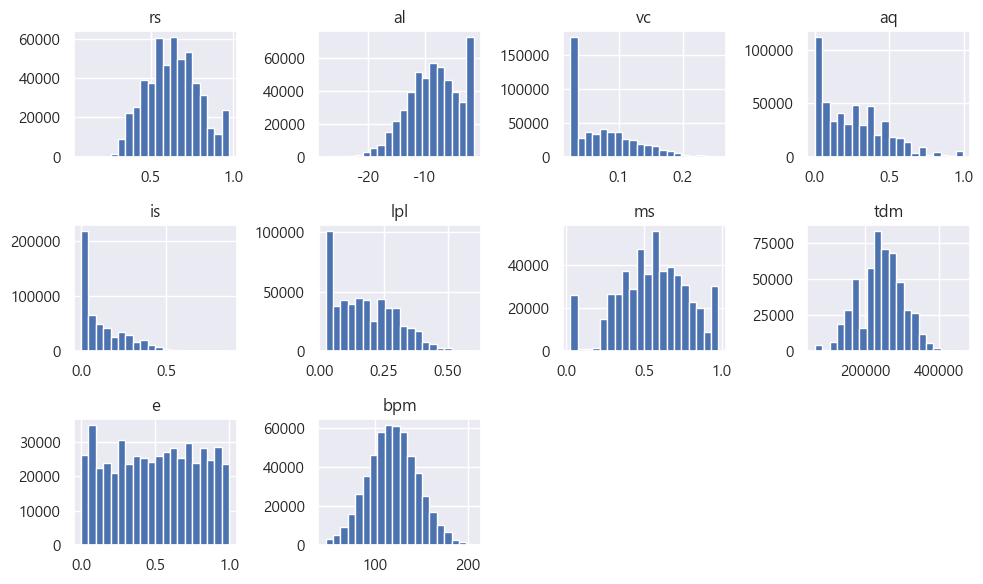

In [41]:
df.hist(figsize=(10, 6), bins=20, layout=(3, 4))
plt.tight_layout()
plt.show()

* 오른쪽으로 심하게 치우친 변수들 (vc, aq, is, lpl, tdm)
* 이 피쳐들은 대부분의 값이 낮은 쪽에 몰려있고, 아웃라이어가 많이 존재
* 왼쪽으로 치우친 변수들 (rs, al, tdm)
* 이 피쳐들은 반대로 대부분의 값이 높은 쪽에 몰려있고, 아웃라이어가 일부 존재

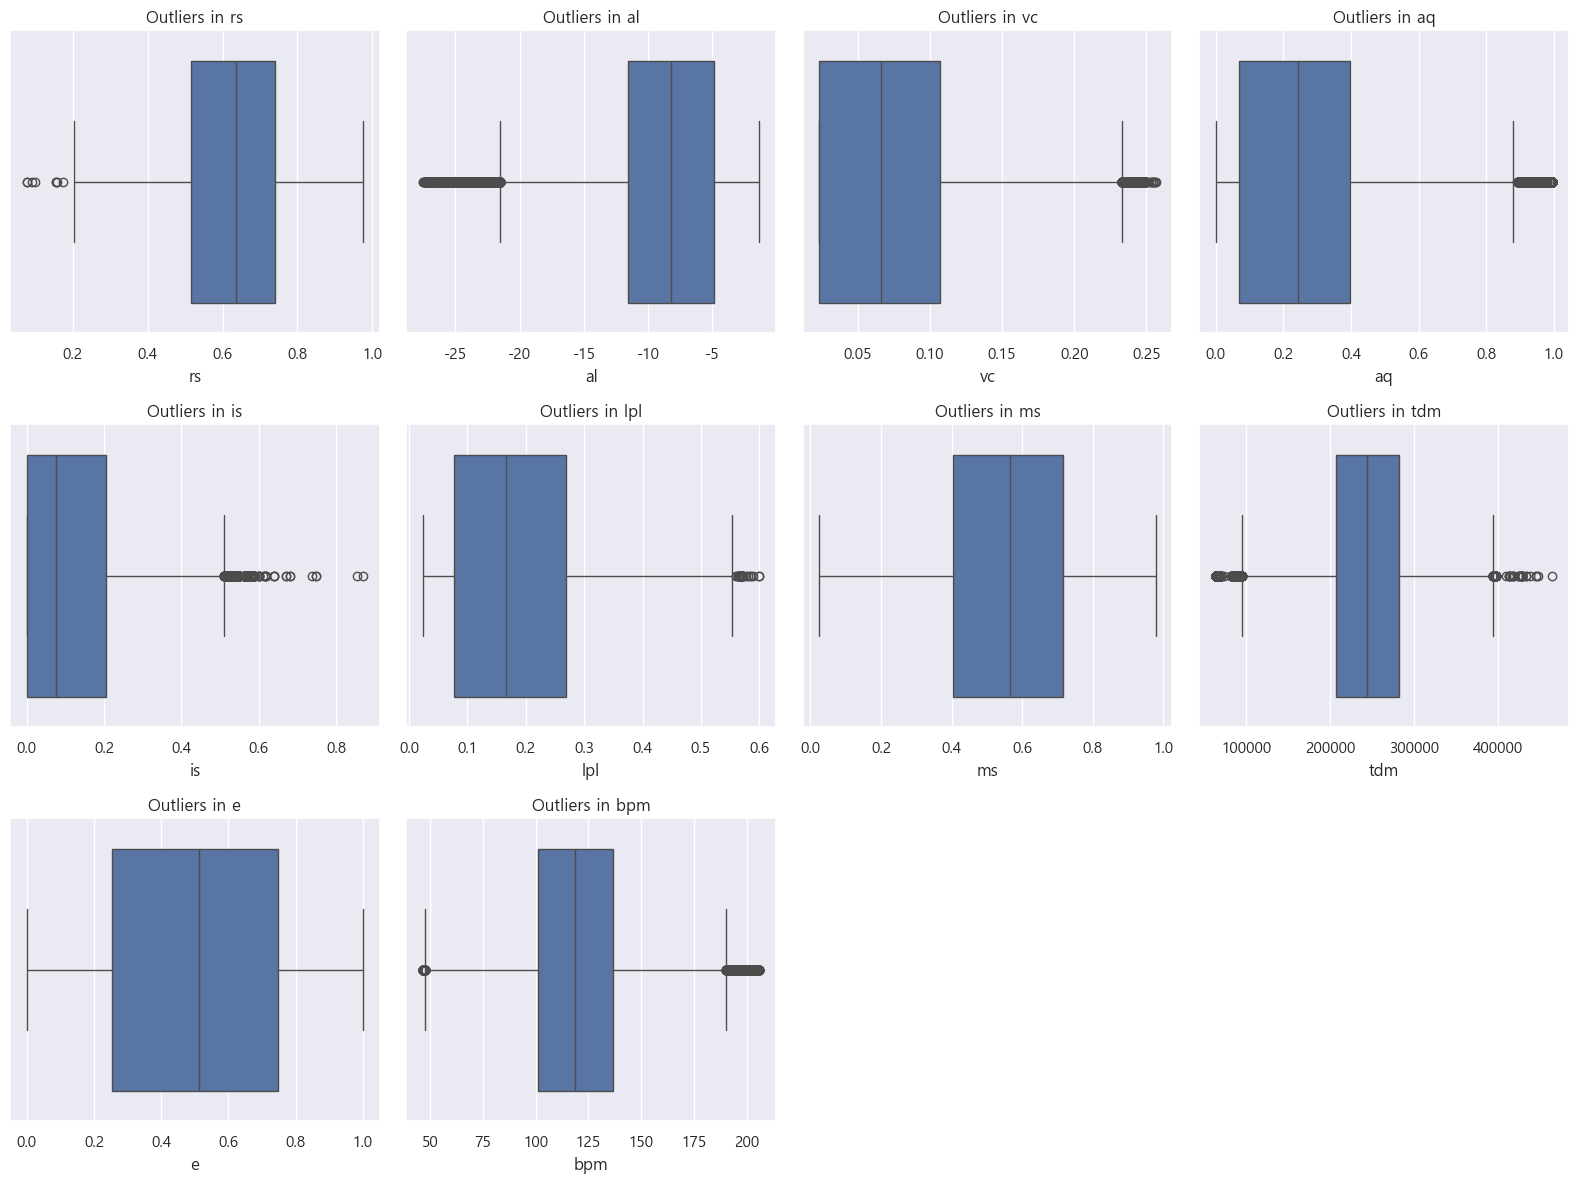

In [50]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

for j in range(len(df.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# 공통함수 myscore

* 기존의 myscore 코드에
* 바로 전 myscore와 점수를 비교할 수 있는 기능과
* feature importance를 볼 수 있는 기능을 추가한 코드

In [62]:
# --- 1. 이전 점수 저장을 위한 전역 변수 ---
previous_scores = None

def myscore(X80=None, y80=None, X20=None, y20=None, model=None, df=None, fi=None, top_n=None):

    # 전역 변수 previous_scores를 함수 내에서 수정할 수 있도록 선언
    global previous_scores

    # --- 2. 데이터 자동 분할 기능 ---
    if df is not None:
        y = df['bpm']
        X = df.drop('bpm', axis=1)
        X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

    # --- 3. 기본 모델 설정 ---
    if model is None:
        model = XGBRegressor(random_state=8989)

    # --- 4. 모델 훈련 및 예측 ---
    model.fit(X80, y80)
    pred = model.predict(X20)

    # --- 5. 모델 성능 평가 ---
    mse = mean_squared_error(y20, pred)
    rmse = root_mean_squared_error(y20, pred)
    r2 = r2_score(y20, pred)
    current_scores = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

    # --- 6. 현재 점수 출력 ---
    print(f'MODEL : {model.__class__.__name__}\nMSE : {mse:.4f}\nRMSE : {rmse:.4f}\nR2 : {r2:.4f}')
    print("-" * 30)

    # --- 7. 이전 점수와 비교하여 성능 변화 출력 ---
    if previous_scores:
        print("--- Score Comparison (Current vs Previous) ---")
        for key, current_val in current_scores.items():
            prev_val = previous_scores.get(key, 0)
            diff = current_val - prev_val
            if key == 'R2':
                is_good = "📈" if diff > 0 else "📉" # R2는 높을수록 좋음
            else:
                is_good = "📈" if diff < 0 else "📉" # MSE, RMSE는 낮을수록 좋음
            print(f'{key:<5}: {current_val:.4f} vs {prev_val:.4f} (Change: {diff:+.4f}) {is_good}')
    else:
        print("첫 번째 실행이므로 비교할 이전 점수가 없습니다.")

    # --- 8. 다음 실행을 위해 현재 점수를 전역 변수에 저장 ---
    print("-" * 30 + "\n")
    previous_scores = current_scores

    # --- 9. Feature Importance 시각화 ---
    if fi:
        if isinstance(model, Pipeline):
            actual_model = model.steps[-1][1]
        else:
            actual_model = model

        if not hasattr(actual_model, 'feature_importances_'):
            print(f"\nNOTE: 이 모델({actual_model.__class__.__name__})은 feature_importances_ 속성이 없습니다.")
            return

        # Feature(변수) 이름과 중요도 점수를 데이터프레임으로 만듦
        importances = actual_model.feature_importances_
        feature_names = X80.columns
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values(by='importance', ascending=False)

        # 그래프 제목을 설정합니다. top_n이 지정되면 제목에 반영
        title_text = f'Feature Importances ({actual_model.__class__.__name__})'
        if top_n is not None:
            fi_df = fi_df.head(top_n)
            title_text = f'Top {top_n} ' + title_text

        # Seaborn을 이용해 Feature Importance를 막대그래프로 그림
        plt.figure(figsize=(12, 6))
        sns.barplot(x='feature', y='importance', data=fi_df)
        plt.title(title_text)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 첫 번째 점수 확인

MODEL : XGBRegressor
MSE : 703.1462
RMSE : 26.5169
R2 : -0.0068
------------------------------
첫 번째 실행이므로 비교할 이전 점수가 없습니다.
------------------------------



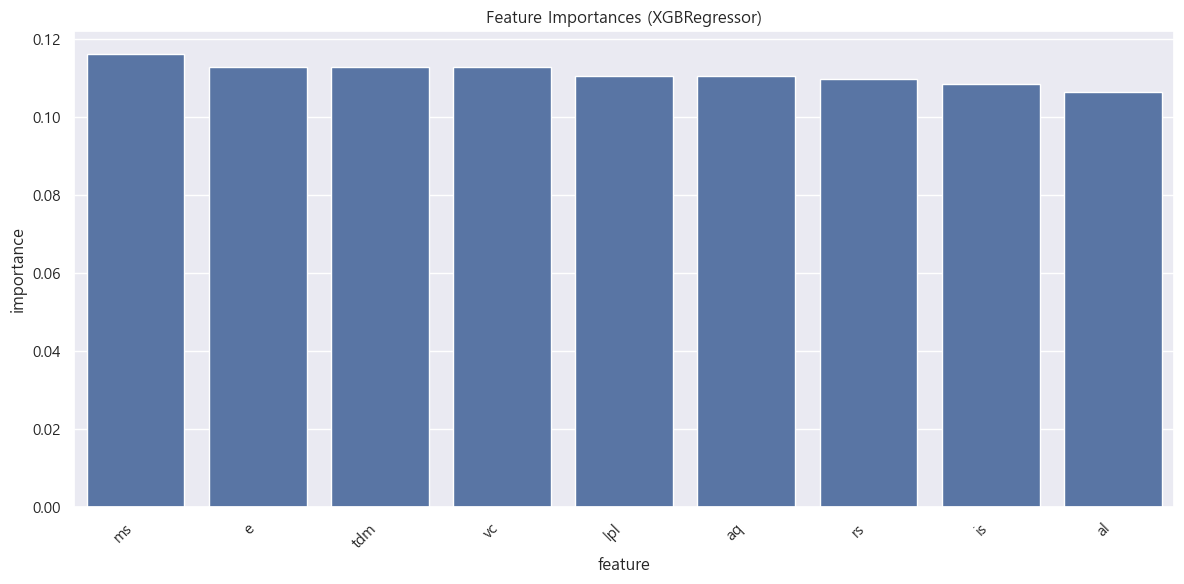

In [63]:
myscore(df=df, fi=True)

# ------- 여기서부터 정리 -------

# 전처리 & 가공

## 이상치 처리

In [58]:
dft = df.copy()
num_features_for_trim = dft.select_dtypes(include=np.number).columns.tolist()
print(">> Trimming Process Start")
print("Original Shape (dft):", dft.shape)

for col in num_features_for_trim:
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

print("Trimmed Shape (dft):", dft.shape)
print("-" * 50)



dfw = df.copy()
num_features_for_winsorize = dfw.select_dtypes(include=np.number).columns.tolist()
print(">> Winsorization Process Start")
print("Original Shape (dfw):", dfw.shape)

for col in num_features_for_winsorize:
    Q1 = dfw[col].quantile(0.25)
    Q3 = dfw[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    dfw[col] = np.where(dfw[col] < lower_bound, lower_bound,
                        np.where(dfw[col] > upper_bound, upper_bound, dfw[col]))

print("Winsorized Shape (dfw):", dfw.shape)

>> Trimming Process Start
Original Shape (dft): (524164, 10)
Trimmed Shape (dft): (505206, 10)
--------------------------------------------------
>> Winsorization Process Start
Original Shape (dfw): (524164, 10)
Winsorized Shape (dfw): (524164, 10)
